# EDA

# El 70-75% de la comida de un supermercado es ultraprocesada, y de ella, un alto porcentaje es insalubre.

### Vamos a comprobarlo usando un *dataset* que contiene todos los productos de Mercadona.
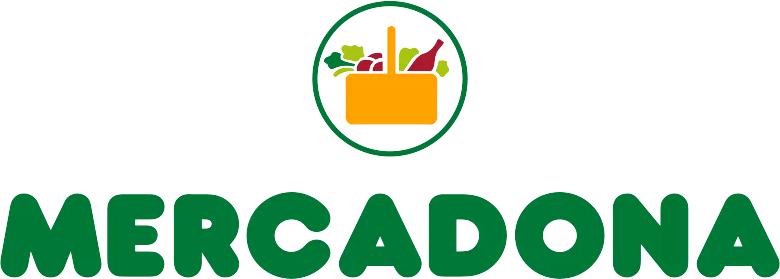

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormapb

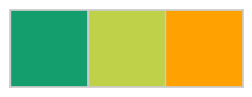

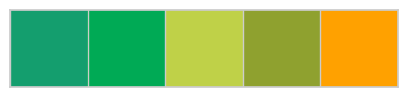

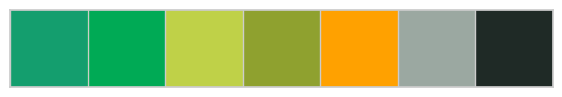

In [67]:
# === Colores base (hex) ===
MDN_GREEN       = "#149E6E"  # primario
MDN_GREEN_ALT   = "#00AA55"  # variante hover/alt
MDN_YELLOWGREEN = "#BFD148"  # secundario
MDN_ORANGE      = "#FFA100"  # acento
UI_WHITE        = "#F9FBF7"  # neutro claro (para fondos)

# === Paletas cualitativas (discretas) ===
mercadona_3  = [MDN_GREEN, MDN_YELLOWGREEN, MDN_ORANGE]
mercadona_5  = [MDN_GREEN, MDN_GREEN_ALT, MDN_YELLOWGREEN, "#8FA12F", MDN_ORANGE]
mercadona_7  = [MDN_GREEN, MDN_GREEN_ALT, MDN_YELLOWGREEN, "#8FA12F", MDN_ORANGE, "#9BA8A1", "#1F2A26"]

# === Mapas de color (continuos) ===
# Secuencial (bueno para intensidades, heatmaps suaves)
mercadona_seq = LinearSegmentedColormap.from_list(
    "mercadona_seq", [MDN_YELLOWGREEN, MDN_GREEN], N=256
)

# Calor desde claro a verde oscuro (para heatmaps con fondo claro)
mercadona_heat = LinearSegmentedColormap.from_list(
    "mercadona_heat", [UI_WHITE, MDN_YELLOWGREEN, MDN_GREEN, "#0B5A41"], N=256
)

# Divergente (valores por encima/debajo de 0, evitar rojos)
mercadona_div = LinearSegmentedColormap.from_list(
    "mercadona_div", [MDN_ORANGE, UI_WHITE, MDN_GREEN], N=256
)

sns.set_theme(style="whitegrid", rc={"axes.facecolor": UI_WHITE})

sns.palplot(sns.color_palette(mercadona_3)); plt.show()
sns.palplot(sns.color_palette(mercadona_5)); plt.show()
sns.palplot(sns.color_palette(mercadona_7)); plt.show()

## Captura inicial de datos
Se escogió el abordaje mediante la API interna de Mercadona, que aunque no está documentada, fue descubierta y estudiada en el pasado por usuarios ávidos de conocimiento.

Para ello, se recurrió a Claude Sonnet 4.5 para generar el script `/src/mercadona_scraper.py` mediante el prompt `/prompts/scraper_script.md`.

### Funcionalidades clave
- ✅ Rastrea IDs de categoría y de producto usando sets (sin duplicados)
- ✅ Esperas aleatorias y educadas (0,5–1,5 segundos entre solicitudes)
- ✅ Gestión de errores con 3 intentos por solicitud
- ✅ Guarda el progreso cada 10 categorías y 50 productos
- ✅ Descarga todas las imágenes en la carpeta ./img/
- ✅ Aplana todas las estructuras anidadas (categories, photos, details, etc)
- ✅ CSV final guardado como `mercadona.csv`

El script muestra el progreso en tiempo real con emojis y contadores para seguir lo que va ocurriendo.


## Primera ronda de limpieza

In [29]:
# Read the API-scraped data
df = pd.read_csv('../data/mercadona.csv')

In [30]:
# id column (product ID) is Float and has xxxx.0
# So it must be converted to string and then we can get rid of the .0
df['id'] = (
    df['id']
      .astype('string')                 # float64 -> StringDtype; NaN becomes <NA>
      .str.replace(r'\.0+\Z', '', regex=True)  # drop only a trailing ".0", ".00", ...
)

In [31]:
# Set the id column as the index
df.set_index('id',inplace=True)

In [32]:
# Remove unnecessary columns
df.drop(['details_suppliers', 'details_legal_name', 'details_description', 'price_price_decreased', 'price_previous_unit_price', 'price_increment_bunch_amount'], axis=1, inplace=True)

In [33]:
# Convert some columns to Pandas integer values, to preserve NaNs as NA
df['img_0_perspective'] = df['img_0_perspective'].astype('Int64')
df['img_1_perspective'] = df['img_1_perspective'].astype('Int64')
df['img_2_perspective'] = df['img_2_perspective'].astype('Int64')
df['img_3_perspective'] = df['img_3_perspective'].astype('Int64')
df['img_4_perspective'] = df['img_4_perspective'].astype('Int64')
df['img_5_perspective'] = df['img_5_perspective'].astype('Int64')
df['img_6_perspective'] = df['img_6_perspective'].astype('Int64')

In [34]:
for x in range(7):
    col_p   = f"img_{x}_perspective"
    col_new = f"img_{x}_nutri_info_file"

    # Boolean mask (treat NA/NaN as False)
    # Perspective 9 is almost always the nutritional info image
    mask = df[col_p].eq(9).fillna(False)

    # Build the full candidate Series once, then keep only masked rows
    s = df.index.to_series().astype(str).add(f"_img_{x}.jpg")
    df[col_new] = s.where(mask, other=pd.NA).astype("string")

In [35]:
# Check result
df.filter(regex=r'^img_')

,img_0_url,img_0_perspective,img_1_url,img_1_perspective,img_2_url,img_2_perspective,img_3_url,img_3_perspective,img_4_url,img_4_perspective,...,img_5_perspective,img_6_url,img_6_perspective,img_0_nutri_info_file,img_1_nutri_info_file,img_2_nutri_info_file,img_3_nutri_info_file,img_4_nutri_info_file,img_5_nutri_info_file,img_6_nutri_info_file
id,,,,,,,,,,,,,,,,,,,,,
46658,https://prod-mercadona.imgix.net/images/5d7b77...,10,https://prod-mercadona.imgix.net/images/30167c...,9,NaN,<NA>,NaN,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,46658_img_1.jpg,<NA>,<NA>,<NA>,<NA>,<NA>
7026,https://prod-mercadona.imgix.net/images/87a727...,1,https://prod-mercadona.imgix.net/images/ae6304...,9,NaN,<NA>,NaN,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,7026_img_1.jpg,<NA>,<NA>,<NA>,<NA>,<NA>
11845,https://prod-mercadona.imgix.net/images/4cd907...,1,https://prod-mercadona.imgix.net/images/8f4afe...,9,NaN,<NA>,NaN,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,11845_img_1.jpg,<NA>,<NA>,<NA>,<NA>,<NA>
35049,https://prod-mercadona.imgix.net/images/564a5f...,1,https://prod-mercadona.imgix.net/images/47dfed...,9,NaN,<NA>,NaN,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,35049_img_1.jpg,<NA>,<NA>,<NA>,<NA>,<NA>
10794,https://prod-mercadona.imgix.net/images/f16c6d...,1,https://prod-mercadona.imgix.net/images/296157...,9,NaN,<NA>,NaN,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,10794_img_1.jpg,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18011,https://prod-mercadona.imgix.net/images/5610e6...,1,https://prod-mercadona.imgix.net/images/d20ac9...,9,NaN,<NA>,NaN,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,18011_img_1.jpg,<NA>,<NA>,<NA>,<NA>,<NA>
17362,https://prod-mercadona.imgix.net/images/b36188...,2,https://prod-mercadona.imgix.net/images/59beb7...,9,NaN,<NA>,NaN,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,17362_img_1.jpg,<NA>,<NA>,<NA>,<NA>,<NA>
46703,https://prod-mercadona.imgix.net/images/751131...,2,https://prod-mercadona.imgix.net/images/929e09...,9,NaN,<NA>,NaN,<NA>,NaN,<NA>,...,<NA>,NaN,<NA>,<NA>,46703_img_1.jpg,<NA>,<NA>,<NA>,<NA>,<NA>


In [36]:
# After a call to a couple of endpoints in Chrome, we get the non-food categories
not_food = ['Limpieza y hogar',
            'Biberón y chupete',
            'Higiene y cuidado',
            'Toallitas y pañales',
            'Cuidado del cabello',
            'Cuidado facial y corporal',
            'Fitoterapia y parafarmacia',
            'Maquillaje',
            'Mascotas'
           ]
# We create a mask for the non-food items
mask = (df['level_0_cat_name'].isin(not_food)) | (df['level_1_cat_name'].isin(not_food)) | (df['level_2_cat_name'].isin(not_food))

# We get a new dataframe with the inverse of the mask (only food items)
df = df[~mask]

# And save it to disk
df.to_csv('../data/mercadona_food_no_nutri.csv')

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3025 entries, 7026 to 11431
Data columns (total 67 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ean                           3025 non-null   int64  
 1   status                        0 non-null      float64
 2   is_bulk                       3025 non-null   bool   
 3   packaging                     2774 non-null   object 
 4   published                     3025 non-null   bool   
 5   share_url                     3025 non-null   object 
 6   display_name                  3025 non-null   object 
 7   is_variable_weight            3025 non-null   bool   
 8   details_brand                 2479 non-null   object 
 9   details_origin                1303 non-null   object 
 10  details_counter_info          96 non-null     object 
 11  details_danger_mentions       0 non-null      object 
 12  details_alcohol_by_volume     173 non-null    object 
 13  deta

## Extracción de los valores nutricionales
Esta vez se recurrió a ChatGPT 5 para la elaboración de la función `extract_nutrition_to_df()` y otras funciones accesorias, que se encuentran en la librería `/src/utils.py`. Para ello, se usó el prompt `/prompts/nutri_script.md`.

A la función `extract_nutrition_to_df()` se le pueden especificar los siguientes argumentos, que flexibilizan y facilitan su uso:
```python
    images_dir: str = "../data/img",
    prompt_path: str = "./nutri_prompt.md",
    model: str = "gpt-4o",
    start_from_id: Optional[int] = None,
    save_every: int = 50,
    out_csv_path: str = "../data/mercadona_food.csv",
```

Se ejecutó un mini-script (`nutri.py`) que carga en un dataframe el archivo `./data/mercadona_food_no_nutri.csv` y llama a la función para enviar a ChatGPT-4o todas las imágenes del producto, extraer todos los datos nutricionales, añadirlos al dataframe y guardarlo a disco como `mercadona_food.csv`.

En cada solicitud y junto a las imágenes, se envió también el prompt `/prompts/nutri_prompt.md`.

En los casos en los que se encontró una tabla con valores nutricionales en alguna de las imágenes del producto, se añadieron los valores en el dataframe.

En los casos en los que no se encontró tabla con valores nutricionales en ninguna de las imágenes del producto, no se escribió ningún valor en el dataframe y los valores nutricionales quedaron como Nan.

Por el contrario, cuando un mismo producto venía con 2 o más tablas nutricionales en varias imágenes, y no existía consenso entre alguno de sus valores, se optó por calcular la media aritmética para cada propiedad, como muestra este extracto del log:

```txt
[69099] CONFLICT: Resolved per-field via consensus/mean.
[69099] RESOLVE valor_energético: mean of [70.0, 62.0] → 66
[69099] RESOLVE grasas: mean of [0.1, 0.5] → 0.30
[69099] RESOLVE grasas_saturadas: mean of [0.03, 0.1] → 0.07
[69099] RESOLVE carbohidratos: mean of [15.7, 12.4] → 14.05
[69099] RESOLVE azúcares: mean of [1.15, 2.0] → 1.57
[69099] RESOLVE proteinas: mean of [2.4, 1.8] → 2.10
[69099] RESOLVE sal: mean of [0.02, 0.1] → 0.06
[69099] OK: Nutrition values written.
```

Tras la ejecución, mi cuenta de OpenAI muestra lo siguiente:
- 2.928 solicitudes
- 7.263.307 tokens
- $16.93 de gasto

## Nueva limpieza

In [38]:
food = pd.read_csv('../data/mercadona_food.csv', index_col='id')

In [39]:
# For some reason, valor_energético is a Float64 now, so convert it to Int64
food['valor_energético'] = food['valor_energético'].astype('Int64')

## Categorización de productos

Nuevamente se recurre a ChatGPT 5 para elaborar las funciones necesarias para esta tarea, que no es trivial, mediante el prompt `./prompts/semáforos.md`. También creo el script `./src/semáforos.py` para ejecutar esta tarea.

### Según su nivel de procesamiento
Usamos NOVA como referencia para clasificar cada producto a partir de su lista de ingredientes (cuando existe) y de la presencia de aditivos “cosméticos” (edulcorantes, colorantes, potenciadores del sabor, emulsificantes, estabilizantes, espesantes, aromas, proteína aislada, almidones modificados, etc), así como de ciertas técnicas industriales (extrusión, moldeado, pre-fritura, recombinación de ingredientes refinados). Concretamos tres etiquetas que se añaden a la columna 'nova_label':
- Min/ingred (NOVA-1/2)
  Alimentos sin procesar o mínimamente procesados y mezclas sencillas de ingredientes culinarios.
- Procesado (NOVA-3)
  Alimentos con sal/azúcar/aceite añadidos u otros procesos simples para conservación o sabor.
- UPF (NOVA-4)
  Formulaciones industriales con predominio de aditivos cosméticos y fracciones de alimentos, diseñadas para hiperpalatabilidad y larga vida útil. Esta categoría se identifica en el parser por la aparición de aditivos/ingredientes indicativos y patrones de proceso. 

Sobre el texto de ingredientes, se van sumando puntos por “señales” de procesado:
- Edulcorantes (aspartamo, acesulfamo, sucralosa, etc.): +2 si aparece ≥1.
- Ingredientes industriales (p. ej., jarabes, aislados/proteínas modificadas, etc.): +1 si aparece ≥1.
- Aditivos “cosméticos” (emulsionantes/estabilizantes, colorantes, potenciadores, etc.):
    - +1 si aparece ≥1,
    - +1 adicional si aparecen ≥2.
- Cantidad de números E-xxx explícitos:
    - +1 si hay ≥2,
    - +1 adicional si hay ≥4.
- Familias de aditivos (p. ej., detectar rango E-220..E-228 “sulfitos”): +1 si aparece ≥1.
- Clases tecnológicas detectadas (conservador/antioxidante, etc.) sin números E-xxx explícitos: +1.
- “procesado culinario” (NOVA-3 de cocina, p. ej. “aceite, sal, vinagre…”) que, si se detecta y no hay edulcorantes, ingredientes industriales ni cosméticos, fuerza la etiqueta “Procesado (NOVA-3)” con score = 0.

Según su `nova_score` (con valores posibles entre 0 y 8), se atribuye una etiqueta `nova_label`:
- score ≥ 3 → UPF (NOVA-4). *UPF: ultraprocessed food*.
- 1 ≤ score ≤ 2 → Procesado (NOVA-3)
- score = 0 → Min/Ingred (NOVA-1/2). *Minimally processed o ingrediente*.
(Con la excepción mencionada: puede ser NOVA-3 con score = 0 si es “culinario”).

### Según sus valores nutricionales
Aplicamos los umbrales de semáforos del sistema FoP del Reino Unido por 100 g (alimentos) y 100 ml (bebidas) para grasa total, grasas saturadas, azúcares totales y sal.

#### Alimentos (por 100 g)
- Rojo (alto): grasa > 17,5 g; saturadas > 5 g; azúcares > 22,5 g; sal > 1,5 g
- Verde (bajo): grasa ≤ 3 g; saturadas ≤ 1,5 g; azúcares ≤ 5 g; sal ≤ 0,3 g
- Ámbar: valores intermedios. 

#### Bebidas (por 100 ml)
- Rojo (alto): grasa > 8,75 g; saturadas > 2,5 g; azúcares > 11,25 g; sal > 0,75 g
- Verde (bajo): grasa ≤ 1,5 g; saturadas ≤ 0,75 g; azúcares ≤ 2,5 g; sal ≤ 0,3 g
- Ámbar: valores intermedios.

#### Reglas adicionales implementadas en el flujo
Con los conteos de semáforos se decide la etiqueta final `tl_decision` así:
- Si reds >= 2 ⇒ no saludable.
- Si greens >= 3 y reds == 0 ⇒ saludable.
- En cualquier otro caso ⇒ a valorar.
- Si no hay tabla nutricional y la categoría `level_2_cat_name` pertenece a grupos frescos (p. ej., Manzana y pera, Fruta tropical, Otras verduras y hortalizas, Vacuno, Pollo, etc), se asignan tres semáforos verdes por defecto.
- Si `level_0_cat_name` == "Bodega", se fuerzan tres semáforos rojos (bebidas alcohólicas).

### Combinación final
La columna `mixed_score` combina calidad nutricional (semáforos) y grado de procesado (NOVA) en una única métrica de 0–100.

1. Puntuación nutricional `N_norm` (0–100)
- Se asignan puntos a los cuatro semáforos:
green = 2, amber = 1, red = 0, y si falta el color None = 1.
- Se suman los 4 nutrientes → máximo N = 8 puntos.
- Se normaliza: `N_norm` = 100 * N / 8.

2. Puntuación de procesado `P_norm` (0–100) a partir de nova_label
- NOVA-4 / "upf"         → P = 0
- NOVA-3 / "procesado"   → P = 2
- NOVA-1/2 (mín./ingred) → P = 3
- `P_norm` = 100 * P / 3

3. “Guardarraíles” por ingredientes (ajustes contextuales)
- Aceites vírgenes 100%/ingrediente único (p. ej., “virgen extra”, “cold pressed” y sin mezcla):
  - si el único rojo es grasa y lo demás es verde, se compensa tratando esa grasa como verde
    - se capan las puntuaciones a `N_norm` ≤ 100.
- Frutos secos 100% (almendra, nuez, avellana, etc.): misma compensación si el único rojo es grasa.
- Bebidas con edulcorantes (si la categoría incluye “bebida” y aparecen edulcorantes tipo aspartamo, sucralosa, etc.):
  - se capan las puntuaciones a `N_norm` ≤ 80 y `P_norm` ≤ 50, y además, si tras el cálculo saliera “Saludable”, se degrada a “A valorar”.
  
4. Mixto final (0–100)
  `mixed_score` = 0.6 * `N_norm` + 0.4 * `P_norm`
Se redondea a una cifra decimal.

5. Etiqueta resultante `mixed_label`
- ≥ 75  → “Saludable”
- 55–74.9 → “A valorar”
- < 55 → “No saludable”


### Fuentes
- Guía oficial del Reino Unido para crear la etiqueta frontal de paquete (FoP) con semáforos — define los umbrales por 100 g y 100 ml para grasa, saturadas, azúcares y sal. Publicada por la Food Standards Agency y el Department of Health and Social Care. 
  [Food Standards Agency](https://www.food.gov.uk/sites/default/files/media/document/fop-guidance_0.pdf?utm_source=chatgpt.com)
- Página del NHS explicando cómo leer las etiquetas y los puntos de corte de “alto/bajo” (incluye la nota de que las bebidas usan criterios distintos). 
  [nhs.uk](https://www.nhs.uk/live-well/eat-well/food-guidelines-and-food-labels/how-to-read-food-labels/?utm_source=chatgpt.com)
- Organizaciones de prestigio que describen los mismos umbrales (divulgación coherente con la guía oficial): British Nutrition Foundation y materiales educativos de diabetes del NHS escocés. 
  [British Nutrition Foundation](https://www.nutrition.org.uk/creating-a-healthy-diet/food-labelling/?utm_source=chatgpt.com)
- FAO (Monteiro *et al*). Ultra-processed foods, diet quality and human health — definición de UPF, características y aditivos cosméticos frecuentes. 
  [Open Knowledge FAO](https://openknowledge.fao.org/server/api/core/bitstreams/5277b379-0acb-4d97-a6a3-602774104629/content?utm_source=chatgpt.com)
- Public Health Nutrition (Monteiro *et al*). Ultra-processed foods: what they are and how to identify them — descripción operativa para identificar UPF. 
  [Public Health Nutr. 2019](https://pmc.ncbi.nlm.nih.gov/articles/PMC10260459/?utm_source=chatgpt.com)
- PAHO/OPS. Ultra-processed food and drink products in Latin America — formulaciones, predominio de aditivos, ejemplos. 
  [iris.paho.org](https://iris.paho.org/xmlui/bitstream/handle/123456789/7699/9789275118641_eng.pdf?utm_source=chatgpt.com)
- CRS (US Congress) y AHA — resúmenes recientes del concepto NOVA-4 y sus descriptores (industriales, aditivos, técnicas). 
  [Congress.gov](https://www.congress.gov/crs-product/IF12826?utm_source=chatgpt.com)

Nota: el sistema de semáforos de UK es voluntario pero ampliamente usado en Reino Unido y está bien documentado. 
[Food Standards Agency](https://www.food.gov.uk/sites/default/files/media/document/fop-guidance_0.pdf?utm_source=chatgpt.com)

Los datos se almacenan en el archivo `../data/mercadona_food_final.csv`

In [45]:
food = pd.read_csv('../data/mercadona_food_final.csv', index_col='id')

In [72]:
food.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3147 entries, 1393 to 92998
Data columns (total 91 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ean                           3147 non-null   int64  
 1   status                        0 non-null      float64
 2   is_bulk                       3147 non-null   bool   
 3   packaging                     2874 non-null   object 
 4   published                     3147 non-null   bool   
 5   share_url                     3147 non-null   object 
 6   display_name                  3147 non-null   object 
 7   is_variable_weight            3147 non-null   bool   
 8   details_brand                 2479 non-null   object 
 9   details_origin                1321 non-null   object 
 10  details_counter_info          218 non-null    object 
 11  details_danger_mentions       0 non-null      float64
 12  details_alcohol_by_volume     173 non-null    object 
 13  deta

## Correlación de Pearson
Para la correlación de Pearson, se mapean las etiquetas a estos *scores*:
  - Min/ingred (NOVA-1/2) → 0
  - Procesado (NOVA-3) → 1
  - UPF (NOVA-4) → 2.
  - saludable → 0
  - a valorar → 1
  - no saludable → 2.

In [96]:
TL_MAP = {
    "saludable": 0,
    "a valorar": 1,
    "no saludable": 2,
}

NOVA_MAP = {
    "Min/Ingred (NOVA-1/2)": 0,
    "Procesado (NOVA-3)": 1,
    "UPF (NOVA-4)": 2,
}

food["tl_cat_score"] = food["tl_decision"].map(TL_MAP)
food["nova_cat_score"] = food["nova_label"].map(NOVA_MAP)

food.to_csv('../data/food_ready_for_EDA.csv')

## Distribución de alimentos según su grado de procesamiento

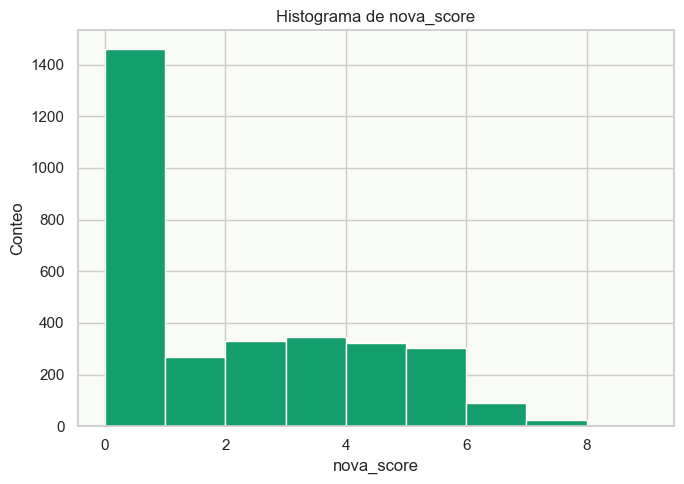

In [99]:
s = food["nova_score"].dropna()

plt.figure(figsize=(7,5))
# Si hay pocos valores distintos, usar bordes enteros; si no, 20 bins
bins = (range(int(s.min()), int(s.max())+2)
        if s.nunique() <= 15 and np.allclose(s, np.round(s))
        else 20)

plt.hist(s, bins=bins, color=MDN_GREEN)
plt.title("Histograma de nova_score")
plt.xlabel("nova_score")
plt.ylabel("Conteo")
plt.tight_layout()
plt.savefig("../presentation/img/histograma_de_nova_score.png", dpi=200, bbox_inches="tight")
plt.show()


- score ≥ 3 → UPF (NOVA-4). *UPF: ultraprocessed food*.
- 1 ≤ score ≤ 2 → Procesado (NOVA-3)
- score = 0 → Min/Ingred (NOVA-1/2). *Minimally processed o ingrediente*.

### Veámoslo colapsado a sus tres categorías

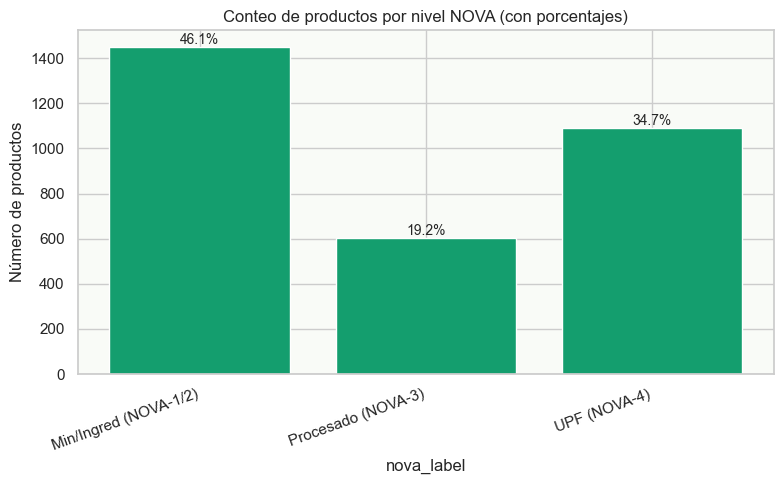

In [100]:
n_cat = food["nova_label"].dropna()

order = ["Min/Ingred (NOVA-1/2)", "Procesado (NOVA-3)", "UPF (NOVA-4)"]

counts = n_cat.value_counts().reindex(order)
total = counts.sum()

x = np.arange(len(counts))
plt.figure(figsize=(8,5))
plt.bar(x, counts.values, color=MDN_GREEN)

# Porcentajes encima de cada barra
for xi, c in zip(x, counts.values):
    p = (c / total) * 100 if total else 0
    plt.text(xi, c, f"{p:.1f}%", ha="center", va="bottom", fontsize=10)

plt.xticks(x, counts.index, rotation=20, ha="right")
plt.ylabel("Número de productos")
plt.xlabel("nova_label")
plt.title("Conteo de productos por nivel NOVA (con porcentajes)")
plt.tight_layout()
plt.savefig("../presentation/img/productos_por_nivel_NOVA.png", dpi=200, bbox_inches="tight")
plt.show()


## Mito refutado para Mercadona

El 70-75% de la comida de un supermercado es ultraprocesada. FALSO.

En Mercadona no llega al 35%. Ni siquiera se cumpliría si agrupáramos los productos procesados y los ultraprocesados.

Y vayamos ahora a por la segunda parte de la afirmación inicial (de los alimentos ultraprocesados, un alto porcentaje es insalubre).

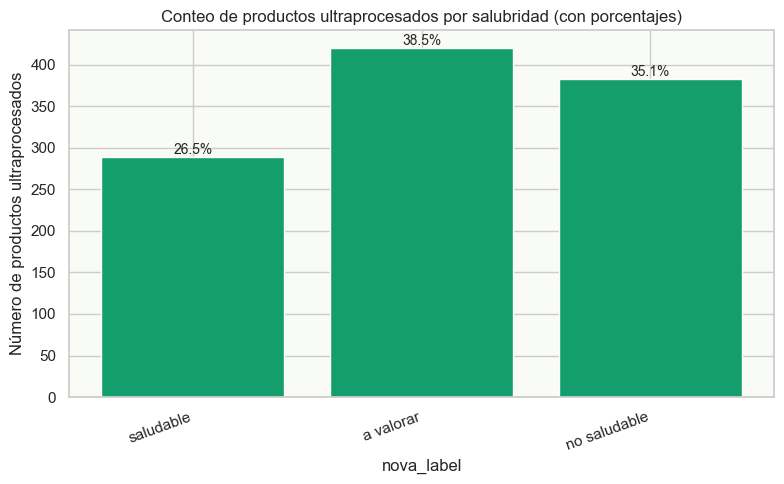

In [101]:
upf = food[food["nova_label"].eq('UPF (NOVA-4)')]
upf_salud = upf['tl_decision']

order = ["saludable", "a valorar", "no saludable"]

counts = upf_salud.value_counts().reindex(order)
total = counts.sum()

x = np.arange(len(counts))
plt.figure(figsize=(8,5))
plt.bar(x, counts.values, color=MDN_GREEN)

# Porcentajes encima de cada barra
for xi, c in zip(x, counts.values):
    p = (c / total) * 100 if total else 0
    plt.text(xi, c, f"{p:.1f}%", ha="center", va="bottom", fontsize=10)

plt.xticks(x, counts.index, rotation=20, ha="right")
plt.ylabel("Número de productos ultraprocesados")
plt.xlabel("nova_label")
plt.title("Conteo de productos ultraprocesados por salubridad (con porcentajes)")
plt.tight_layout()
plt.savefig("../presentation/img/productos_UPF_por_salubridad.png", dpi=200, bbox_inches="tight")
plt.show()


El resultado no es para tirar cohetes, pero un 35% no es un "alto porcentaje".

## Así que podemos afirmar que nuestra hipótesis inicial no se confirma.

## Sigamos explorando
## Correlación de Pearson

Eliminadas por constancia: ['status', 'sodio']


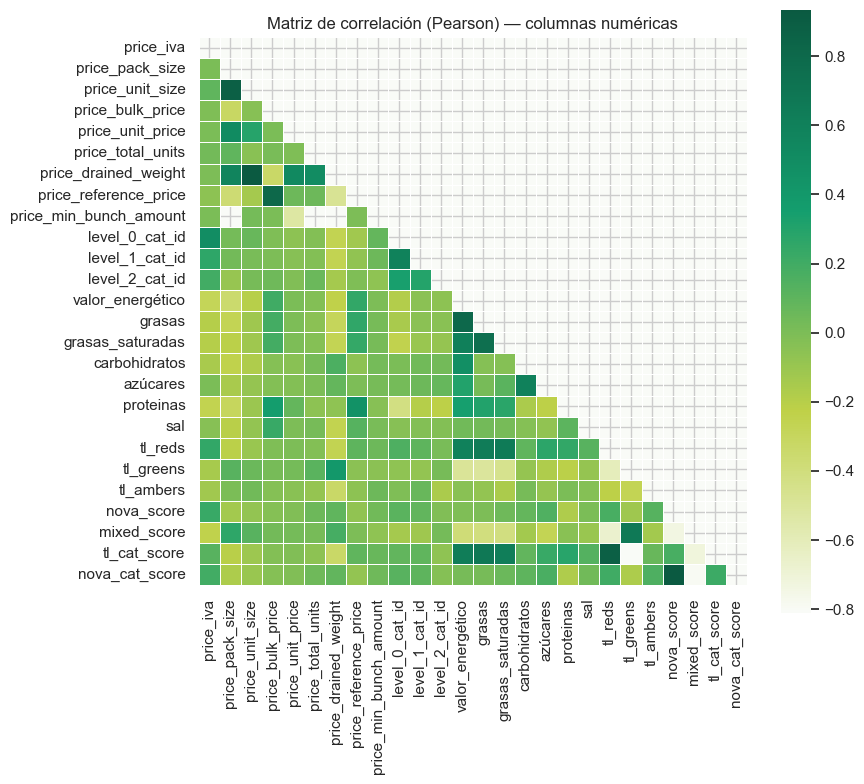

In [98]:
# Seleccionamos columnas numéricas
num_cols = [
    'status', 
    'price_iva', 
    'price_pack_size', 
    'price_unit_size', 
    'price_bulk_price', 
    'price_unit_price', 
    'price_total_units', 
    'price_drained_weight', 
    'price_reference_price', 
    'price_min_bunch_amount', 
    'level_0_cat_id', 
    'level_1_cat_id', 
    'level_2_cat_id', 
    'valor_energético', 
    'grasas', 
    'grasas_saturadas', 
    'carbohidratos', 
    'azúcares', 
    'proteinas', 
    'sal', 
    'sodio', 
    'tl_reds', 
    'tl_greens', 
    'tl_ambers', 
    'nova_score', 
    'mixed_score', 
    'tl_cat_score', 
    'nova_cat_score'
]

X = food[num_cols].copy()

# Quitamos columnas con varianza cero (o todo NaN)
const_mask = X.nunique(dropna=True) <= 1
if const_mask.any():
    print("Eliminadas por constancia:", X.columns[const_mask].tolist())
    X = X.loc[:, ~const_mask]

corr = X.corr(method="pearson")

# Heatmap (enmascarar triángulo superior para mayor legibilidad)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(max(8, 0.35*len(corr.columns)), max(6, 0.35*len(corr.columns))))
sns.heatmap(
    corr,
    mask=mask,
    annot=False,
    cmap=mercadona_heat,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Matriz de correlación (Pearson) — columnas numéricas")
plt.tight_layout()
plt.savefig("../presentation/img/pearson_corr_heatmap.png", dpi=200, bbox_inches="tight")
plt.show()

Esperaba ver una correlación fuertemente positiva entre las columnas `tl_cat_score` y `nova_cat_score`. 

Al menos es positiva…

Las correlaciones fuertemente positivas son obvias:
- Entre `nova_cat_score` y `nova_score`. La primera es pseudo-categórica (0, 1, 2) y la segunda son enteros positivos (de 0 a 8). Y vienen a indicar lo mismo, el grado de procesamiento de un alimento.
- Entre `tl_cat_score` y `tl_reds`. Si `tl_cat_score` = 2 (no saludable) es porque el producto tiene 2 o más semáforos rojos.
- Entre `mixed_score` y `tl_greens`. Porque `mixed_score` va al revés (0: no saludable; 100: saludable). Cuantos más semáforos verdes tenga un producto, más saludable es.
- Entre `tl_cat_score` y `valor_energético`, `grasas`, `grasas_saturadas`. Cuanto mayor sea uno (0: saludable; 2: no saludable), mayores son los otros.
- Entre `tl_reds` y `valor_energético`, `grasas`, `grasas_saturadas`. Cuanto más semáforos rojos tenga un producto es porque mayores son los valores de las grasas y grasas saturadas. Y como también hay fuerte correlación positiva entre las grasas y el valor energético…
- Entre `axúcares` y `carbohidratos`. Obvio. Los azúcares son carbohidratos.
- Entre `grasas_saturadas` y `grasas`. Obvio. Las grasas saturadas son grasas.
- Entre `grasas` o `grasas_saturadas` y `valor_energético`. Las grasas son muy densas calóricamente. Más que los carbohidratos.
- Etc.
